# Objetivo:

Previsão do preço de ações da empresa Alibaba

In [ ]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
df = pd.read_csv('Ali_Baba_Stock_Data.csv')

In [ ]:
df.dtypes

,0
Date,object
Adj Close,float64
Close,float64
High,float64
Low,float64
Open,float64
Volume,int64


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
df

,Date,Adj Close,Close,High,Low,Open,Volume
0,2014-09-19,90.673950,93.889999,99.699997,89.949997,92.699997,271879400
1,2014-09-22,86.810966,89.889999,92.949997,89.500000,92.699997,66657800
2,2014-09-23,84.184128,87.169998,90.480003,86.620003,88.940002,39009800
3,2014-09-24,87.467667,90.570000,90.570000,87.220001,88.470001,32088000
4,2014-09-25,85.874191,88.919998,91.500000,88.500000,91.089996,28598000
...,...,...,...,...,...,...,...
2612,2025-02-07,103.510002,103.510002,107.510002,103.000000,104.459999,39538200
2613,2025-02-10,111.320000,111.320000,111.650002,106.699997,107.320000,42429400
2614,2025-02-11,112.779999,112.779999,115.540001,111.000000,113.959999,55001300
2615,2025-02-12,118.330002,118.330002,119.809998,114.964996,115.820000,44024700


In [ ]:
df1 = df.copy()

In [ ]:
df1['Volume'] = df1['Volume'].astype('int')

In [ ]:
df1['Date']

,Date
0,2014-09-19
1,2014-09-22
2,2014-09-23
3,2014-09-24
4,2014-09-25
...,...
2612,2025-02-07
2613,2025-02-10
2614,2025-02-11
2615,2025-02-12


In [ ]:
df2 = df.copy()

In [ ]:
df2.head(1)

,Date,Adj Close,Close,High,Low,Open,Volume
0,2014-09-19,90.67395,93.889999,99.699997,89.949997,92.699997,271879400


In [ ]:
df2.isna().sum()

,0
Adj Close,0
Close,0
High,0
Low,0
Open,0
Volume,0


In [ ]:
df2 = df2.set_index('Date')

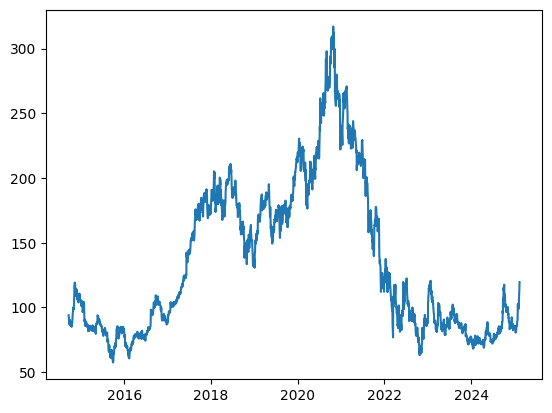

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd


plt.plot(df2['Close'])
plt.show()

In [ ]:
result = seasonal_decompose(df2['Close'], model='additive', period=365)

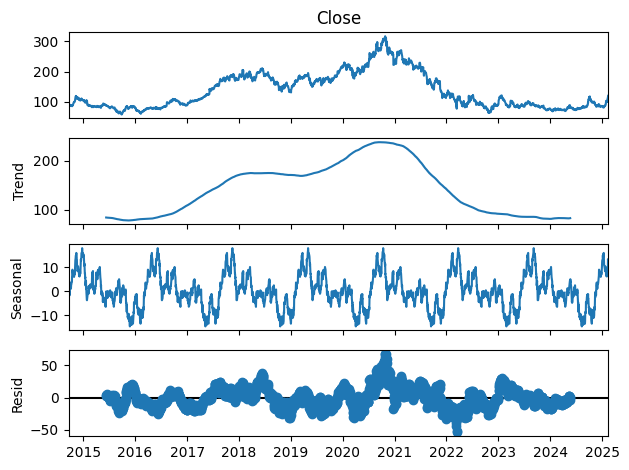

In [ ]:
result.plot()
plt.show()

Análise:

- Possui uma sazonalidade anual com padrões bem estabelecidos.
- A tendência, principalmente após a pandemia, cai drasticamente
- Podemos ver que as ações subiram bastante na pandemia. Nesses anos muitas pessoas foram trabalhar remotamente devido a quarentena, então as altas das ações deve ser da alta demanda de produtos eletronicos

In [ ]:
df2.drop('Close', axis=1).shape

(2617, 6)

## Criaçao do modelo Close


In [ ]:
import torch.nn as nn
import torch

class LSTM_AliBaba(nn.Module):

  def __init__(self):
    super().__init__()
    self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
    self.linear = nn.Linear(50,1)

  def forward(self, x):

    # Passando pela LSTM
    lstm_out, _ = self.lstm(x.unsqueeze(1))  # Adicione uma dimensão para os recursos, se necessário
    # Passando pela camada linear
    output = self.linear(lstm_out)
    return output


AliBaba = LSTM_AliBaba() #

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Movendo o modelo para o dispositivo (GPU se disponível, senão CPU)
AliBaba.to(device)

loss_fn = nn.MSELoss() # Change to MSELoss for regression
optimizer = torch.optim.Adam(AliBaba.parameters(), lr=1e-3)

print(AliBaba)

LSTM_AliBaba(
  (lstm): LSTM(1, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)


In [ ]:
def train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  for batch, (X, y) in enumerate(dataloader): # Em Python, enumerate() é uma função útil para iterar sobre uma sequência (como uma lista, tupla ou string) e obter ao mesmo tempo o índice e o valor de cada elemento.
    model.train()
    optimizer.zero_grad()
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    loss.backward()
    optimizer.step()


    if batch % 100 == 0:
        loss, current = loss.item(), (batch + 1) * len(X)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")




In [ ]:
df3 = df.copy()

In [ ]:
df_train = df3.iloc[:1962]
df_test = df3.iloc[1962:]



In [ ]:
X_train = df_train['Close']
y_train = df_train['Close']

X_test = df_test['Close']
y_test = df_test['Close']

In [ ]:
X_train

,Close
0,93.889999
1,89.889999
2,87.169998
3,90.570000
4,88.919998
...,...
1957,116.029999
1958,113.680000
1959,116.000000
1960,120.129997


In [ ]:
from torch.utils.data import TensorDataset, DataLoader

# Transformando os dados em tensores e adicionando ao DataLoader
#

batch_size = 8

X_test_numeric = X_test.apply(pd.to_numeric, errors='coerce')
X_test = torch.tensor(X_test_numeric.values, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test.values, dtype=torch.float32).to(device)
test_dataset = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size)

X_train_numeric = X_train.apply(pd.to_numeric, errors='coerce')
X_train = torch.tensor(X_train_numeric.values, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train.values, dtype=torch.float32).to(device)
train_dataset = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size)

In [ ]:
for batch, (X, y) in enumerate(train_dataset):
    print(f"Shape do batch X: {X.shape}")
    print(f"Shape do batch y: {y.shape}")
    break  # Imprime apenas o formato do primeiro batch

Shape do batch X: torch.Size([8])
Shape do batch y: torch.Size([8])


In [ ]:
epochs = 200

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    print(f'\nTraining: \n')
    train(train_dataset, AliBaba, loss_fn, optimizer)
    print(f'\nTesting: \n')
    #test(test_dataset, AliBaba, loss_fn)
    size = len(test_dataset.dataset) # Tamanho do dataset de test
    num_batches = len(test_dataset) # Quantidade de batchs. O que no nosso caso é 8
    AliBaba.eval() # Avaliação do modelo
    test_loss, correct = 0, 0 # Inicialização das variáveis
    with torch.no_grad(): # Segue a explicação abaixo do uso dessa função
      '''
      Disabling gradient calculation is useful for inference,
      when you are sure that you will not call Tensor.backward().
      It will reduce memory consumption for computations that would otherwise have requires_grad=True.
      '''

      for X, y in test_dataset:
            X, y = X.to(device), y.to(device) # Transferindo dados para a GPU
            pred = AliBaba(X)
            test_loss += loss_fn(pred, y).item() # Calculando o quanto o modelo errou
            correct += (pred.argmax(1) == y).type(torch.float).sum().item() # calcula o número de previsões corretas em um batch, o converte em um número Python e o adiciona a um acumulador.
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: Avg loss: {test_loss:>8f} \n")
    if test_loss < 141:
      break

    #test(test, AliBaba, loss_fn, optimizer)


Epoch 1
-------------------------------

Training: 

loss: 8084.285645  [    8/ 1962]


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 31566.291016  [  808/ 1962]
loss: 61111.511719  [ 1608/ 1962]

Testing: 

Test Error: Avg loss: 4978.844590 

Epoch 2
-------------------------------

Training: 

loss: 5364.881836  [    8/ 1962]


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 27221.335938  [  808/ 1962]
loss: 55624.507812  [ 1608/ 1962]

Testing: 

Test Error: Avg loss: 3513.440958 

Epoch 3
-------------------------------

Training: 

loss: 3816.664551  [    8/ 1962]
loss: 23883.623047  [  808/ 1962]
loss: 51059.140625  [ 1608/ 1962]

Testing: 

Test Error: Avg loss: 2473.447583 

Epoch 4
-------------------------------

Training: 

loss: 2706.005615  [    8/ 1962]
loss: 20964.162109  [  808/ 1962]
loss: 46706.835938  [ 1608/ 1962]

Testing: 

Test Error: Avg loss: 1622.156108 

Epoch 5
-------------------------------

Training: 

loss: 1783.345581  [    8/ 1962]
loss: 18345.394531  [  808/ 1962]
loss: 42882.375000  [ 1608/ 1962]

Testing: 

Test Error: Avg loss: 1019.047752 

Epoch 6
-------------------------------

Training: 

loss: 1115.356934  [    8/ 1962]
loss: 16075.480469  [  808/ 1962]
loss: 39431.468750  [ 1608/ 1962]

Testing: 

Test Error: Avg loss: 598.850006 

Epoch 7
-------------------------------

Training: 

loss: 633.911255  [    8

In [ ]:
y_pred = AliBaba(X_test)

In [ ]:
from sklearn.metrics import root_mean_squared_error

root_mean_squared_error(y_pred.cpu().detach().numpy(), y_test.cpu())

4.326599597930908

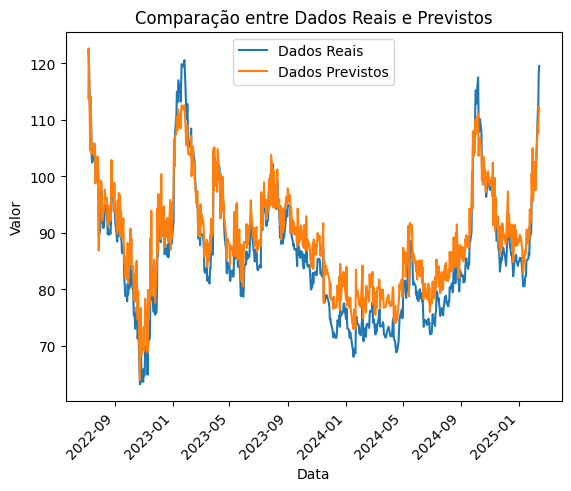

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd  # Import pandas for date handling

dates = df_test['Date'].values  #  the dates

# Dados reais e previstos
dados_reais = y_test.cpu()
dados_previstos = y_pred.cpu().detach().numpy()

plt.plot(dates, dados_reais, label='Dados Reais')
plt.plot(dates, dados_previstos, label='Dados Previstos')

plt.title('Comparação entre Dados Reais e Previstos')
plt.xlabel('Data')  # Change x-axis label to 'Data'
plt.ylabel('Valor')
plt.legend()

plt.xticks(rotation=45, ha='right')

# Exiba o gráfico
plt.show()

### Salvando melhores modelos

In [ ]:

torch.save(AliBaba, 'AliBaba1.pth')

In [ ]:
root_mean_squared_error(y_pred.cpu().detach().numpy(), y_test.cpu())
torch.save(AliBaba, 'AliBaba4.3.pth')

## Criação de Modelo com variável de abertura


In [ ]:
df3

,Date,Adj Close,Close,High,Low,Open,Volume
0,2014-09-19,90.673950,93.889999,99.699997,89.949997,92.699997,271879400
1,2014-09-22,86.810966,89.889999,92.949997,89.500000,92.699997,66657800
2,2014-09-23,84.184128,87.169998,90.480003,86.620003,88.940002,39009800
3,2014-09-24,87.467667,90.570000,90.570000,87.220001,88.470001,32088000
4,2014-09-25,85.874191,88.919998,91.500000,88.500000,91.089996,28598000
...,...,...,...,...,...,...,...
2612,2025-02-07,103.510002,103.510002,107.510002,103.000000,104.459999,39538200
2613,2025-02-10,111.320000,111.320000,111.650002,106.699997,107.320000,42429400
2614,2025-02-11,112.779999,112.779999,115.540001,111.000000,113.959999,55001300
2615,2025-02-12,118.330002,118.330002,119.809998,114.964996,115.820000,44024700


In [ ]:
import numpy as np
class LSTM_AliBaba(nn.Module):

  def __init__(self): # Add input_size as an argument
    super().__init__()
    self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
    self.linear = nn.Linear(50,1)

  def forward(self, x):
    # Passando pela LSTM
    lstm_out, _ = self.lstm(x.unsqueeze(1))  # Adicione uma dimensão para os recursos, se necessário
    # Pegando apenas a saída da última sequência
    # Passando pela camada linear
    output = self.linear(lstm_out)
    return output


AliBaba = LSTM_AliBaba() #

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Movendo o modelo para o dispositivo (GPU se disponível, senão CPU)
AliBaba.to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(AliBaba.parameters(), lr=1e-3)

print(AliBaba)

LSTM_AliBaba(
  (lstm): LSTM(1, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)


In [ ]:
def train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  for batch, (X, y) in enumerate(dataloader): # Em Python, enumerate() é uma função útil para iterar sobre uma sequência (como uma lista, tupla ou string) e obter ao mesmo tempo o índice e o valor de cada elemento.
    model.train()
    optimizer.zero_grad()
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    rmse_loss = torch.sqrt(loss) # Adicionando RMSE para melhor métrica de treino
    loss.backward()
    optimizer.step()


    #if batch % 100 == 0:
        #loss, current = loss.item(), (batch + 1) * len(X)
        #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    if batch % 100 == 0:
        loss_value, current = rmse_loss.item(), (batch + 1) * len(X)
        print(f"RSME Loss: {loss_value:>7f}  [{current:>5d}/{size:>5d}]")


Foi realizada uma pequena modificação para melhor visualização de acurácia utilizando o RMSE, sendo o mesmo a raiz quadrada do MSE

In [ ]:
df_train = df3.iloc[:1962]
df_test = df3.iloc[1962:]

X_train = df_train['Open']
y_train = df_train['Open']

X_test = df_test['Open']
y_test = df_test['Open']

In [ ]:
X_test_numeric = X_test.apply(pd.to_numeric, errors='coerce')
X_test = torch.tensor(X_test_numeric.values, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test.values, dtype=torch.float32).to(device) -
test_dataset = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size)

X_train_numeric = X_train.apply(pd.to_numeric, errors='coerce')
X_train = torch.tensor(X_train_numeric.values, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train.values, dtype=torch.float32).to(device)
train_dataset = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size)

In [ ]:
epochs = 200

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    print(f'\nTraining: \n')
    train(train_dataset, AliBaba, loss_fn, optimizer)
    print(f'\nTesting: \n')
    #test(test_dataset, AliBaba, loss_fn)
    size = len(test_dataset.dataset) # Tamanho do dataset de test
    num_batches = len(test_dataset) # Quantidade de batchs. O que no nosso caso é 64
    AliBaba.eval() # Avaliação do modelo
    test_loss, correct = 0, 0 # Inicialização das variáveis
    with torch.no_grad(): # Segue a explicação abaixo do uso dessa função
      '''
      Disabling gradient calculation is useful for inference,
      when you are sure that you will not call Tensor.backward().
      It will reduce memory consumption for computations that would otherwise have requires_grad=True.
      '''

      for X, y in test_dataset:
            X, y = X.to(device), y.to(device) # Transferindo dados para a GPU
            pred = AliBaba(X)
            test_loss += loss_fn(pred, y).item() # Calculando o quanto o modelo errou
            correct += (pred.argmax(1) == y).type(torch.float).sum().item() # calcula o número de previsões corretas em um batch, o converte em um número Python e o adiciona a um acumulador.
    test_loss /= num_batches

    correct /= size
    test_rmse = np.sqrt(test_loss)  # Adicionando o RMSE para melhor métrica
    print(f"Test Error: Avg loss: {test_loss:>8f}, RMSE: {test_rmse:>8f} \n") #

    if test_rmse < 11:
      break


Epoch 1
-------------------------------

Training: 

RSME Loss: 90.565186  [    8/ 1962]


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RSME Loss: 180.194077  [  808/ 1962]
RSME Loss: 250.809982  [ 1608/ 1962]

Testing: 

Test Error: Avg loss: 5353.744992, RMSE: 73.169290 

Epoch 2
-------------------------------

Training: 

RSME Loss: 76.387444  [    8/ 1962]


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RSME Loss: 168.688004  [  808/ 1962]
RSME Loss: 239.175919  [ 1608/ 1962]

Testing: 

Test Error: Avg loss: 3763.763219, RMSE: 61.349517 

Epoch 3
-------------------------------

Training: 

RSME Loss: 64.387924  [    8/ 1962]
RSME Loss: 158.211807  [  808/ 1962]
RSME Loss: 228.796997  [ 1608/ 1962]

Testing: 

Test Error: Avg loss: 2609.010056, RMSE: 51.078470 

Epoch 4
-------------------------------

Training: 

RSME Loss: 53.891502  [    8/ 1962]
RSME Loss: 147.746384  [  808/ 1962]
RSME Loss: 218.830383  [ 1608/ 1962]

Testing: 

Test Error: Avg loss: 1734.006075, RMSE: 41.641399 

Epoch 5
-------------------------------

Training: 

RSME Loss: 44.138775  [    8/ 1962]
RSME Loss: 138.401184  [  808/ 1962]
RSME Loss: 209.775848  [ 1608/ 1962]

Testing: 

Test Error: Avg loss: 1104.706107, RMSE: 33.237119 

Epoch 6
-------------------------------

Training: 

RSME Loss: 35.282871  [    8/ 1962]
RSME Loss: 129.738876  [  808/ 1962]
RSME Loss: 201.283920  [ 1608/ 1962]

Testing: 

Te

In [ ]:
y_pred  = AliBaba(X_test)

In [ ]:
root_mean_squared_error(y_pred.cpu().detach().numpy(), y_test.cpu())

7.183845520019531

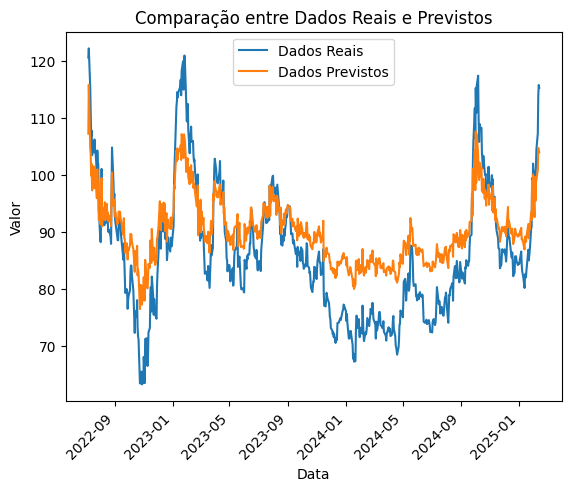

In [ ]:
dates = df_test['Date'].values

dados_reais = y_test.cpu()
dados_previstos = y_pred.cpu().detach().numpy()

plt.plot(dates, dados_reais, label='Dados Reais')
plt.plot(dates, dados_previstos, label='Dados Previstos')

plt.title('Comparação entre Dados Reais e Previstos')
plt.xlabel('Data')  # Change x-axis label to 'Data'
plt.ylabel('Valor')
plt.legend()

plt.xticks(rotation=45, ha='right')

plt.show()

In [ ]:
root_mean_squared_error(y_pred.cpu().detach().numpy(), y_test.cpu())


7.183845520019531

In [ ]:
root_mean_squared_error(y_pred.cpu().detach().numpy(), y_test.cpu())
torch.save(AliBaba, 'AliBaba_Open7.18.pth')

## Conclusão

Conseguimos bons resultados para ambos "Close" e "Open", mas o Open não se encaixou nos dados de forma tão boa quanto Close.

Apesar das pesquisas não consegui procurar o contexto da época, mas presumo que houve algum fator que mudou o humor dos investidores. Em períodos de insegurança como guerras, resultados ruins de empresas, mercado de trabalho de um país pode afetar o humor dos investidores, o que pode oscilar para cima ou para baixo o valor das ações.